In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import os
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yihim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
df = pd.read_csv("dataset/training.1600000.processed.noemoticon.csv", encoding="latin", header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns = ["sentiment", "id", "date", "query", "user_id", "text"]
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.drop(["id", "date", "query", "user_id"], axis = 1, inplace=True)

In [6]:
df.sentiment.value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

# Text preprocessing

In [7]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [8]:
def preprocess_text(text, stem=False):
    text = re.sub(text_cleaning_re, " ", str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [97]:
dump({"stop_words": stop_words,
      "stemmer": stemmer,
      "text_cleaning_re": text_cleaning_re},
     filename="preprocess_text.joblib")

['preprocess_text.joblib']

In [9]:
df.sentiment = df.sentiment.replace({4:1})

In [10]:
df.sentiment.value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

In [11]:
df.text = df.text.apply(lambda x: preprocess_text(x))

# Visualize positive words

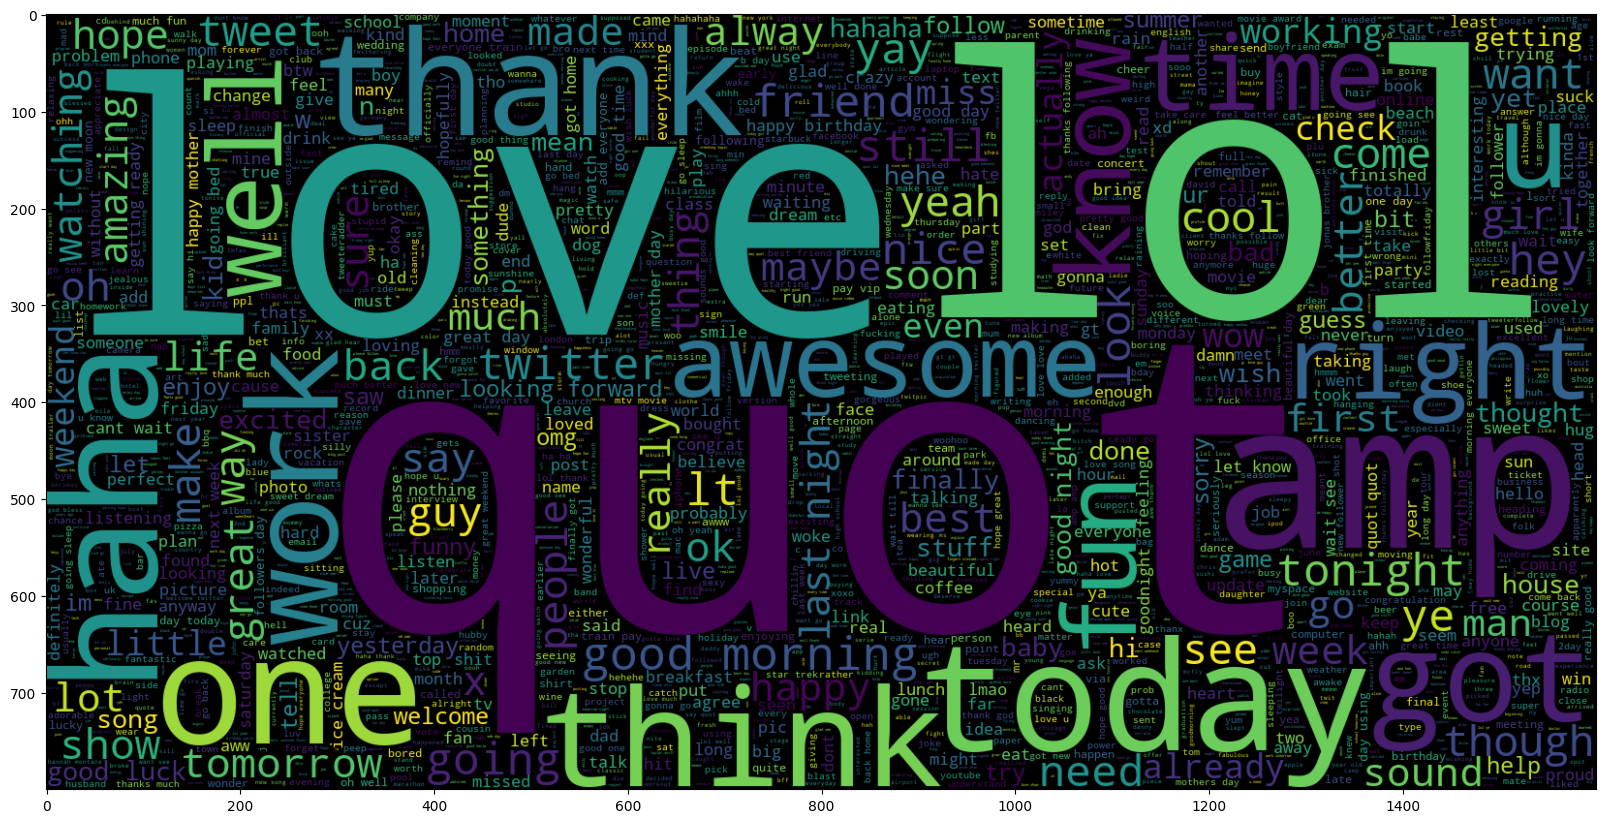

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.sentiment == 1].text))
plt.imshow(wc, interpolation="bilinear")

# Visualize negative words

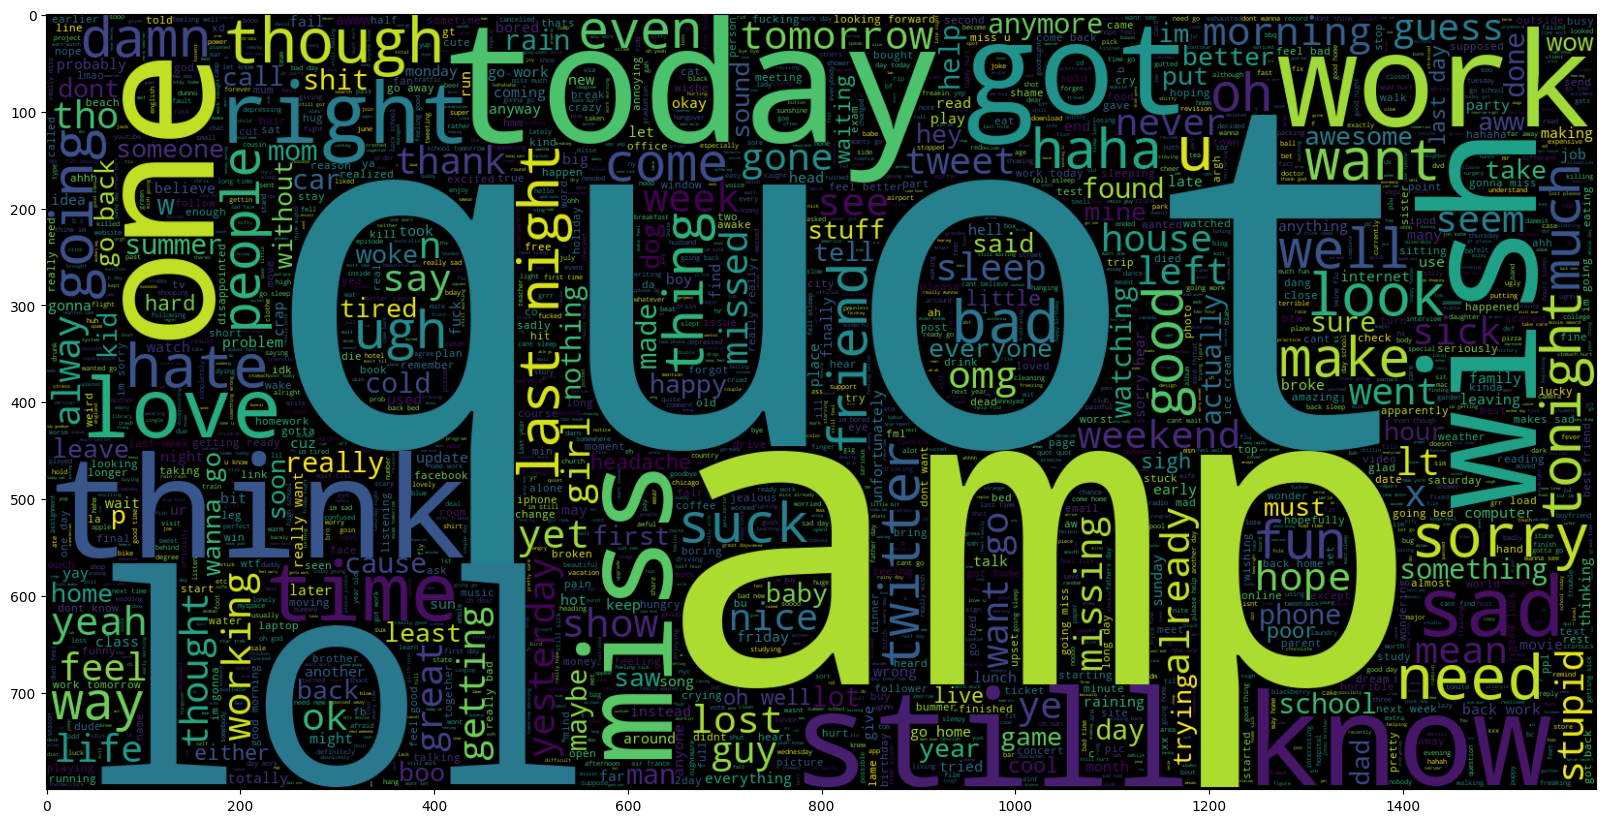

In [13]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc, interpolation="bilinear")

# Splitting into train and test

In [14]:
sentences = df.text.to_numpy()
labels = df.sentiment.to_numpy()

In [15]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences,
                                                                            labels,
                                                                            test_size=0.2,
                                                                            random_state=42)

In [16]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(1280000, 1280000, 320000, 320000)

In [107]:
# train_sentences = train_sentences[:int(0.01 * len(train_sentences))]
# train_labels = train_labels[:int(0.01 * len(train_labels))]

# val_sentences = val_sentences[:int(0.01 * len(val_sentences))]
# val_labels = val_labels[:int(0.01 * len(val_labels))]

# Creating the TextVectorization

In [17]:
sentence_len = [len(sentence.split()) for sentence in train_sentences]
mean_sentence_len = np.mean(sentence_len)
mean_sentence_len

7.208753125

In [18]:
max_length = int(np.percentile(sentence_len, 98))
max_length

16

In [19]:
max_vocab_length = 290000
max_length = int(np.percentile(sentence_len, 98))

text_vectorizer = layers.TextVectorization(max_tokens=max_vocab_length,
                                           output_mode="int",
                                           output_sequence_length=max_length)

text_vectorizer.adapt(train_sentences)

In [20]:
word_index = text_vectorizer.get_vocabulary()
vocab_size = len(word_index)

In [21]:
train_sentences_vectorized = text_vectorizer(train_sentences)
val_sentences_vectorized = text_vectorizer(val_sentences)

In [89]:
from joblib import dump, load

In [91]:
dump({"config": text_vectorizer.get_config(),
      "weights": text_vectorizer.get_weights()},
     filename="sentiment140_text_vectorizer.joblib")

['sentiment140_text_vectorizer.joblib']

# Creating the Glove Embeddings

In [124]:
!curl -L -o glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   308    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   346    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0  822M    0  447k    0     0   121k      0  1:55:13  0:00:03  1:55:10  391k
  0  822M    0 5567k    0     0  1235k      0  0:11:21  0:00:04  0:11:17 2821k
  2  822M    2 18.4M    0     0  3411k      0  0:04:06  0:00:05  0:04:01 6280k
  3  822M    3 27.8M    0     0  4380k      0  0:03:12  0:00:06  0:03:06 7165k
  4  822M    4 32.8M    0     0  4488k      0  0:03:07  0:00:07  0:03:00 6775k
  4  822M    4 37.9M    0     0  4573k      0  0:

In [122]:
!mkdir glove_embed

In [125]:
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip")
zip_ref.extractall("glove_embed/")
zip_ref.close()

In [23]:
GLOVE_EMB = "glove_embed/glove.6B.300d.txt"
EMBEDDING_DIM = 300

In [24]:
embeddings_index = {}
with open(GLOVE_EMB, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in zip(word_index, range(1, vocab_size)):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
text_embedding = layers.Embedding(vocab_size,
                                  EMBEDDING_DIM,
                                  weights=[embedding_matrix],
                                  input_length=max_length,
                                  trainable=False)

# Callbacks

In [36]:
def tensorboard_cb(dirpath, model_name):
    return tf.keras.callbacks.TensorBoard(os.path.join(dirpath, 
                                                       model_name, 
                                                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

def checkpoint_cb(dirpath, model_name, save_format=None, save_weights=False):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(dirpath, model_name + save_format), 
                                              save_best_only=True, 
                                              save_weights_only=save_weights,
                                              monitor="val_loss",
                                              verbose=1)

def early_stopping_cb(patience):
    return tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            restore_best_weights=True, 
                                            patience=patience,
                                            verbose=1)

def reduce_lr_cb(patience, factor):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                patience=patience, 
                                                factor=factor, 
                                                min_lr=1e-7,
                                                verbose=1)

In [37]:
LOGS_PATH = "model_logs/"

In [27]:
def create_performant_features_targets(features, targets, batch_size=32, pre=False, map_func=None, shuffle=False, shuffle_size=None):
    """
    Create a performant dataset for escalating efficiency during training/evaluating a model.

    Parameters:
    - features: numpy array, input features
    - targets: numpy array, target values
    - batch_size: int, batch size for the dataset
    - pre: bool, whether to apply a preprocessing function
    - map_func: function, preprocessing function to be applied if pre=True
    - shuffle: bool, whether to shuffle the dataset
    - shuffle_size: int, size of the shuffle buffer

    Returns:
    - tf.data.Dataset: TensorFlow dataset
    """

    features_tensor = tf.data.Dataset.from_tensor_slices(features)
    targets_tensor = tf.data.Dataset.from_tensor_slices(targets)
    dataset_tensor = tf.data.Dataset.zip((features_tensor, targets_tensor))

    if pre:
        dataset_tensor = dataset_tensor.map(map_func=map_func, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset_tensor = dataset_tensor.shuffle(shuffle_size)

    dataset_tensor = dataset_tensor.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset_tensor

In [110]:
train_dataset = create_performant_features_targets(train_sentences, train_labels)
val_dataset = create_performant_features_targets(val_sentences, val_labels)

In [111]:
train_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [112]:
len(train_dataset), len(val_dataset)

(40000, 10000)

# Universal Sentence Encoder

In [23]:
import tensorflow_hub as hub

In [25]:
hub_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [53]:
embeddings = hub_embed([train_sentences[0],
                        train_sentences[1]])

print(embeddings)

tf.Tensor(
[[ 0.06195429 -0.04420915 -0.05430772 ... -0.02561674 -0.06825186
  -0.01295965]
 [ 0.01201256 -0.03407939  0.00788345 ... -0.06383099 -0.05021283
  -0.07235834]], shape=(2, 512), dtype=float32)


In [29]:
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           input_shape=[],
                           dtype=tf.string,
                           trainable=False,
                           name="USE_layer")

In [108]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

inputs = layers.Input(shape=(), dtype=tf.string)
x = use_layer(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs, name="use_model")

In [109]:
model.summary()

Model: "use_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 257,060,993
Trainable params: 263,169
Non-t

In [113]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model_history = model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=100,
                          callbacks=[tensorboard_cb(LOGS_PATH, model.name),
                                     checkpoint_cb("", model.name, save_format=".h5"),
                                     early_stopping_cb(5),
                                     reduce_lr_cb(3, 0.1)])

Epoch 1/100
39997/40000 [============================>.] - ETA: 0s - loss: 0.5293 - accuracy: 0.7326
Epoch 1: val_loss improved from inf to 0.49731, saving model to use_model.h5
40000/40000 [==============================] - 839s 21ms/step - loss: 0.5293 - accuracy: 0.7326 - val_loss: 0.4973 - val_accuracy: 0.7605 - lr: 0.0010
Epoch 2/100
40000/40000 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.7398
Epoch 2: val_loss improved from 0.49731 to 0.49518, saving model to use_model.h5
40000/40000 [==============================] - 931s 23ms/step - loss: 0.5198 - accuracy: 0.7398 - val_loss: 0.4952 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 3/100
40000/40000 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7421
Epoch 3: val_loss improved from 0.49518 to 0.49510, saving model to use_model.h5
40000/40000 [==============================] - 907s 23ms/step - loss: 0.5172 - accuracy: 0.7421 - val_loss: 0.4951 - val_accuracy: 0.7648 - lr: 0.0010
Epoch

KeyboardInterrupt: 

# TextVectorization Layer with Glove Embeddings

In [28]:
train_dataset_vectorized = create_performant_features_targets(train_sentences_vectorized, train_labels, batch_size=1024)
val_dataset_vectorized = create_performant_features_targets(val_sentences_vectorized, val_labels, batch_size=1024)

In [29]:
train_dataset_vectorized, val_dataset_vectorized

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [143]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

inputs = layers.Input(shape=(max_length,), dtype=tf.int64)
x = text_embedding(inputs)
x = layers.Bidirectional(layers.LSTM(100, dropout=0.3, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(100, dropout=0.3, return_sequences=True))(x)
x = layers.Conv1D(100, 5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")

In [144]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 300)           87000000  
                                                                 
 bidirectional (Bidirectiona  (None, 16, 200)          320800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 12, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0   

In [145]:
model_2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_2_history = model_2.fit(train_dataset_vectorized,
                              validation_data=val_dataset_vectorized,
                              epochs=100,
                              callbacks=[tensorboard_cb(LOGS_PATH, model_2.name),
                                         checkpoint_cb("", model_2.name, save_format=".h5"),
                                         early_stopping_cb(5),
                                         reduce_lr_cb(3, 0.1)])

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7127
Epoch 1: val_loss improved from inf to 0.49700, saving model to model_2.h5
1250/1250 [==============================] - 132s 101ms/step - loss: 0.5489 - accuracy: 0.7127 - val_loss: 0.4970 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7519
Epoch 2: val_loss improved from 0.49700 to 0.48038, saving model to model_2.h5
1250/1250 [==============================] - 192s 153ms/step - loss: 0.5010 - accuracy: 0.7519 - val_loss: 0.4804 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.7611
Epoch 3: val_loss improved from 0.48038 to 0.47321, saving model to model_2.h5
1250/1250 [==============================] - 161s 129ms/step - loss: 0.4879 - accuracy: 0.7611 - val_loss: 0.4732 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 4/100
1250/125

# Try different layers

In [146]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

inputs = layers.Input(shape=(max_length,), dtype=tf.int64)
x = text_embedding(inputs)
x = layers.SpatialDropout1D(0.2)(x)
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")

In [147]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 300)           87000000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 16, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 12, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               6604

In [148]:
model_3.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_3_history = model_3.fit(train_dataset_vectorized,
                              validation_data=val_dataset_vectorized,
                              epochs=100,
                              callbacks=[tensorboard_cb(LOGS_PATH, model_3.name),
                                         checkpoint_cb("", model_3.name, save_format=".h5"),
                                         early_stopping_cb(5),
                                         reduce_lr_cb(3, 0.1)])

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.6899
Epoch 1: val_loss improved from inf to 0.52130, saving model to model_3.h5
1250/1250 [==============================] - 267s 209ms/step - loss: 0.5737 - accuracy: 0.6899 - val_loss: 0.5213 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7320
Epoch 2: val_loss improved from 0.52130 to 0.50454, saving model to model_3.h5
1250/1250 [==============================] - 270s 216ms/step - loss: 0.5270 - accuracy: 0.7320 - val_loss: 0.5045 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7417
Epoch 3: val_loss improved from 0.50454 to 0.49887, saving model to model_3.h5
1250/1250 [==============================] - 274s 219ms/step - loss: 0.5140 - accuracy: 0.7417 - val_loss: 0.4989 - val_accuracy: 0.7535 - lr: 0.0010
Epoch 4/100
1250/125

# Visualizing the best model results - model_2

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

In [65]:
def evaluate_classification_model(y_true, y_preds):
    """
    Evaluate a classification model for binary/multi-class classification.

    Parameters:
    - y_true: 1D array or list of actual values.
    - y_preds: 1D array or list of predicted values.

    Returns:
    - evaluation_results: Dictionary containing evaluation metrics.
    """
    acc = accuracy_score(y_true, y_preds)
    pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_preds, average="weighted", zero_division=1)
    return {"acc": acc,
            "pre": pre,
            "rec": rec,
            "f1": f1}

In [32]:
model_2_loaded = tf.keras.models.load_model("model_2.h5")
model_2_preds = model_2_loaded.predict(val_dataset_vectorized)

In [45]:
val_labels[:40]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [49]:
model_2_preds = tf.cast(tf.round(model_2_preds), dtype=tf.int64)

In [51]:
model_2_preds = tf.squeeze(model_2_preds)

In [52]:
model_2_preds[:40]

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)>

In [66]:
model_2_results = evaluate_classification_model(val_labels, model_2_preds)
model_2_results

{'acc': 0.784934375,
 'pre': 0.7851376765785874,
 'rec': 0.784934375,
 'f1': 0.7848829569464068}

In [59]:
cm = confusion_matrix(val_labels, model_2_preds)
cm

array([[122850,  36644],
       [ 32177, 128329]], dtype=int64)

In [67]:
# [[True Negative  False Positive]
#  [False Negative True Positive]]

In [57]:
import seaborn as sns

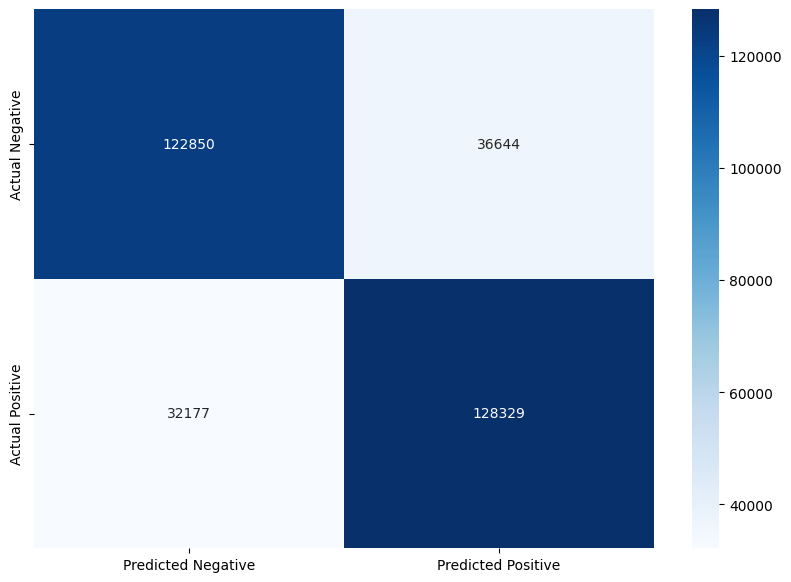

In [60]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm,
            annot=True,
            cmap="Blues",
            fmt="d",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.show()

# Testing with examples

In [98]:
neg_example = "Just had the worst experience at the customer service center. No one seemed to care about my issue. Frustrating!"
pos_example = "Had an amazing day at the beach with friends! The weather was perfect, and the laughter was contagious. #Grateful"

cleaned_neg_example = preprocess_text(neg_example)
cleaned_pos_example = preprocess_text(pos_example)

In [99]:
neg_example = text_vectorizer(cleaned_neg_example)
pos_example = text_vectorizer(cleaned_pos_example)

In [100]:
neg_example, pos_example

(<tf.Tensor: shape=(16,), dtype=int64, numpy=
 array([ 584, 1276, 2827,  847, 1851,   17, 2669,  430, 1647, 2662,    0,
           0,    0,    0,    0,    0], dtype=int64)>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=
 array([ 143,    3,  331,  113,  179,  541, 5097, 9177, 3223,    0,    0,
           0,    0,    0,    0,    0], dtype=int64)>)

In [101]:
model_2_loaded.predict(tf.expand_dims(neg_example, axis=0))

array([[0.01989618]], dtype=float32)

In [102]:
model_2_loaded.predict(tf.expand_dims(pos_example, axis=0))

array([[0.99310815]], dtype=float32)

In [92]:
loaded_config_weights = load("sentiment140_text_vectorizer.joblib")

In [93]:
new_tv = layers.TextVectorization().from_config(loaded_config_weights["config"])

In [94]:
new_tv.adapt(["xyz"])

In [95]:
new_tv.set_weights(loaded_config_weights["weights"])

In [104]:
new_tv(cleaned_pos_example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([ 143,    3,  331,  113,  179,  541, 5097, 9177, 3223,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>